# Kinetic Component Analysis (KCA)

## Introduction

In this writing, we present results of applying Kinetic Component Analysis (KCA) to various futures contract prices. KCA is a novel state-state application where it applies a Kalman Filter on a Taylor Series expansion of a stochastic process. KCA as compared to other noise-reducing methods has several interesting qualities:
- KCA provides additional information such as velocity and acceleration ("first and second derivatives of the position in state-space")
- KCA provides band estimates / confidence intervals in addition to point estimates
- KCA provides forecasting capabilities that other algorithms such as FFT and LOWESS dont provide

We perform some initial exploration of KCA over gold futures price path. We then see how well KCA performs at performing forecasts over future price movements.

### Data exploration

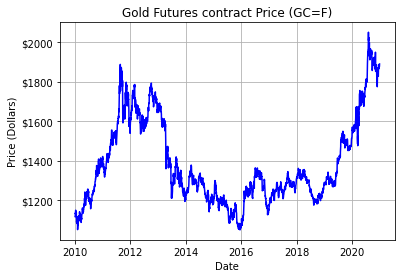

In [1]:
import pandas as pd
from src.plotting import plot_gold_future_price

futures_data = pd.read_csv('data/futures.csv', header=[0,1], index_col=0)
futures_data.index = pd.to_datetime(futures_data.index)

futures_universe = futures_data.iloc[:]["Adj Close"]
gold_futures = futures_universe["GC=F"].to_frame()

plot_gold_future_price(gold_futures)

We download some sample future price data to use with KCA. We have saved the top 10 futures contract prices as weighed by volume. We select these given these would be the most liquid and data rich. Throughout, we will be exploring gold futures in more depth. Above we see gold futures contract price for the past 10 years (2010-2020)

In [2]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(gold_futures, test_size=0.05, shuffle=False)
validate = train.copy(deep=True)

To prep the data for usage with our KCA algorithm we split it between training and test sets. We will use the training set to perform the initial fit and see how well KCA performs. The test set will be used later to test its forecasting capabilities. We also create a validation set to use with out KCA trading class in later cells.

In [3]:
from src.kca import fitKCA
from src.utils import split_price_time_series

price_series, time_series = split_price_time_series(train)

x_mu, x_std, x_covar = fitKCA(time_series, price_series, 1000)

In the above cell we split price and time series for our gold futures price training set and feed it to the `fitKCA` function. We note that the `fitKCA` function is a functionally equivalent implementation to the original paper. The only modifications made have been for styling purposes.

In [4]:
from src.utils import add_kca_results

trained = add_kca_results(train, x_mu, x_std)

trained

,GC=F,KCA_position,KCA_velocity,KCA_position_std
Date,,,,
2010-01-04,1117.699951,558.5,1.110772e-39,7.071068e-01
2010-01-05,1118.099976,1118.0,2.282221e-12,9.141969e+19
2010-01-06,1135.900024,1135.0,5.938129e-14,9.038631e+19
2010-01-07,1133.099976,1133.0,1.187626e-14,9.038631e+19
2010-01-08,1138.199951,1138.0,6.729879e-14,9.038631e+19
...,...,...,...,...
2020-06-05,1676.199951,1676.0,-7.917505e-14,9.038631e+19
2020-06-08,1698.300049,1698.0,1.504326e-13,9.038631e+19
2020-06-09,1714.699951,1714.0,5.938129e-14,9.038631e+19


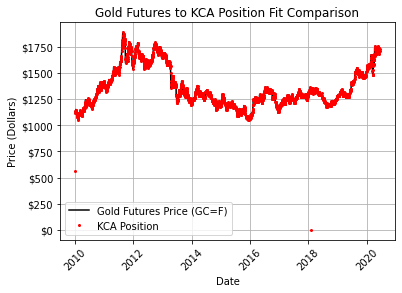

In [5]:
from src.plotting import plot_gold_future_to_kca_position, plot_gold_kca_position_velocity

plot_gold_future_to_kca_position(trained)

In the above figure we can appreciate how well KCA fits the provided training set for gold futures contract price path. We do highlight two anomalies. First, at the beggining in 2010 we see the fit wasnt as good. This is expected and the paper explains this is due to Kalman filters converging on true values asymtotically. Hence, it will take a few initial observations to converge to the actual price path. Here we see it happened quite quickly.

The second anomaly can be seen a bit after year 2018. For now, we lack an explanation for such a deviation.

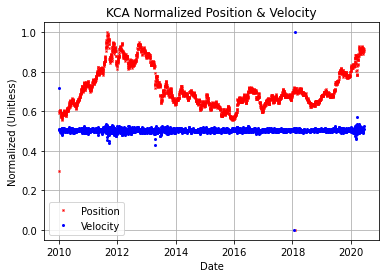

In [6]:
plot_gold_kca_position_velocity(trained)

From our KCA fit we also get a velocity component, which can be thought of as how quick the position is moving in state-space. There are interesting relationships here and in fact it does seem to coincide with large spikes in price movements. However, we have no special statistical relationships established at the moment that could prove relevant for us.

## KCA Trading with Gold Futures

In [7]:
from src.trading import generate_trade_signal, KCAStrategy

signal = generate_trade_signal(validate)
print("Prediction: {prediction}, Decision: {decision}".format(prediction=signal[0], decision="Buy" if signal[1] == 1 else "Sell"))
%timeit generate_trade_signal(validate)

/home/gsmadi/Dev/oct_applications_21/gsmadi/src/kca.py:55: RuntimeWarning: invalid value encountered in sqrt
  x_std_ = x_covar[:, i, i]**.5


Prediction: 1770.999994151051, Decision: Buy


/home/gsmadi/Dev/oct_applications_21/gsmadi/src/kca.py:53: RuntimeWarning: invalid value encountered in sqrt
  x_std = (x_covar[:, 0, 0]**.5).reshape(-1, 1)


9.36 s ± 133 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Above is a our `generate_trade_signal` function which take in a price signal and produces a trade decision with a price prediction for the next given day.

We note that the function make use of `fitKCA` and we observe on average the fitting routine takes around 10 seconds.

In [8]:
from src.utils import execute_kca_rolling_window_fit

kca = KCAStrategy(validate)
kca = execute_kca_rolling_window_fit(kca, test, days=10)

kca.observations.tail()

,GC=F,prediction,decision
Date,,,
2020-06-17,1745.900024,1714.000000,-1.0
2020-06-18,1756.699951,1791.999999,1.0
2020-06-19,1772.099976,1757.000002,1.0
2020-06-20,1765.800049,1793.000000,1.0
2020-06-21,1762.099976,1735.000000,-1.0


Above we execute our rolling window function using our `KCAStrategy` class for trading. As we can see, our class produces predictions for next day prices with decisions to buy or sell given the market price the day in which the prediction for created. A decision of 1 signifies a **buy** order and a -1 a **sell**.

Once we produce a forecast of the next day price, we extract the actual price from our test set create in previous cells. We do this to compare how well the algorithm actually predicted the price.

To recap, we have used `KCAStrategy` to produce predictions for next day prices and we eventually add the actual price to the date from our test sample set for comparison.

In [9]:
predictions = kca.observations[~kca.observations['prediction'].isnull()]

predictions.head()

,GC=F,prediction,decision
Date,,,
2020-06-12,1729.300049,1771.0,1.0
2020-06-13,1720.300049,1704.0,-1.0
2020-06-14,1729.599976,1705.0,-1.0
2020-06-15,1729.199951,1756.0,1.0
2020-06-16,1724.800049,1720.0,-1.0


In [10]:
from src.utils import set_outcomes_of_predictions

predictions['prediction_delta'] = predictions.iloc[:, 0] - predictions['prediction']
predictions = set_outcomes_of_predictions(predictions)

predictions

/home/gsmadi/Dev/oct_applications_21/gsmadi/venv/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/gsmadi/Dev/oct_applications_21/gsmadi/src/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['outcome'] = np.NAN
/home/gsmadi/Dev/oct_applications_21/gsmadi/venv/lib/python3.7/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to b

,GC=F,prediction,decision,prediction_delta,outcome
Date,,,,,
2020-06-12,1729.300049,1771.000000,1.0,-41.699951,0.0
2020-06-13,1720.300049,1704.000000,-1.0,16.300049,0.0
2020-06-14,1729.599976,1705.000000,-1.0,24.599976,0.0
2020-06-15,1729.199951,1756.000000,1.0,-26.800049,0.0
2020-06-16,1724.800049,1720.000000,-1.0,4.800049,0.0
2020-06-17,1745.900024,1714.000000,-1.0,31.900024,0.0
2020-06-18,1756.699951,1791.999999,1.0,-35.300048,0.0
2020-06-19,1772.099976,1757.000002,1.0,15.099974,1.0
2020-06-20,1765.800049,1793.000000,1.0,-27.199951,0.0


Now that we have produced predictions and we know the actual values from our test set samples, lets see how well KCA fares. To see how well KCA performs we essentially see if it was right in direction in regard to the price movement and by how much.

In the `prediction_delta` column we take the difference from the actual to the predicted value. Using the sign of this value and of the decision we create the `outcome` column. In this column, if the direction produced by KCA was correct we set a `1`, else a `0` for wrong.

Computing a hit-to-miss ratio below, we see its not the greatest. Essentially, predicting 10 days worth of price movements, it only got 1 right. Now, lets highlight how little data we have to make conclusions on this.

In [11]:
from src.utils import compute_hit_to_miss_ratio

print("KCA hit-miss ratio: {ratio}".format(ratio=compute_hit_to_miss_ratio(predictions)))

KCA hit-miss ratio: 0.1


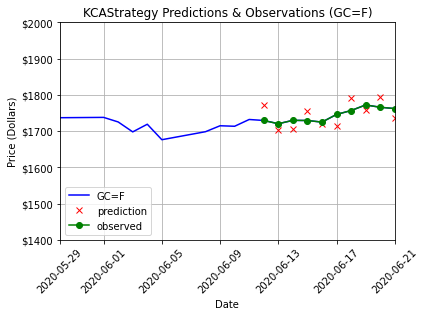

In [12]:
from src.plotting import plot_gold_kca_strategy

plot_gold_kca_strategy(kca, predictions)

## Conclusion

We saw how KCA can be applied to futures price signals, equivalent to noisy signals, and extract some interesting and perhaps meaningful information. While, this study is not comprehensive of KCA capabilities, we do note that the original KCA paper did not provide any experimental results. This was an initial red flag for its capabilities as applied to stochastic processes such as futures or other asset prices. The original paper does some initial presentation of the algorithm as applied to a sinusoid with some guassian noise. While it worked well in the example it is quite different to a stochastic process such as futures prices.

While we cant conclude much given how small our sample results are we can ponder on how to improve and perhaps get strong confidence in future experimentation with KCA.

### Improvements

There are several steps we can take to improve experimental results with KCA in the future. The first we propose is speeding up the fitting routine to be able to crunch more
data in a shorter time span.

Another avenue to explore is different time resolutions. Perhaps larger cycles such as 5 or 10 year time length could improve forcasting. Conversely, smaller minute resolution time frame could also provide insights.

Next time, if we can obtain more results and establish stronger statistical significance we could come to better conclusions as to KCA capabilities for forecasting noisy signals.